In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = './hw3.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,subject_id,hadm_id,stay_id,age,gender,resp_rate_mean,heart_rate_max,glucose_max,hemoglobin_min,hemoglobin_max,glucose_avg,vasopressin,urineoutput,label
0,10015272,27993466,37267577,78,F,23.863636,145.0,174.0,9.3,9.4,135.5,0,400.0,0
1,10018928,22523751,35050109,31,F,18.703704,100.0,204.0,11.5,13.3,111.0,0,1330.0,0
2,10020852,23525237,35919245,31,F,17.961538,93.0,99.0,12.8,13.4,99.0,0,NaN,0
3,10023404,28217007,33958400,28,F,15.708333,88.0,NaN,NaN,NaN,NaN,0,NaN,0
4,10026255,22059910,31248398,67,M,24.400000,120.0,85.0,11.5,11.5,85.0,0,690.0,1


## Data Pre-processing

In [2]:
# Identifying numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols.remove('label')  # Remove the target variable
numerical_cols.remove('subject_id')  # Remove the subject_id variable
numerical_cols.remove('hadm_id')  # Remove the hadm_id variable
numerical_cols.remove('stay_id')  # Remove the stay_id variable
print(numerical_cols)

# Preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Splitting the dataset into features and target variable
X = data.drop('label', axis=1)
y = data['label']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


['age', 'resp_rate_mean', 'heart_rate_max', 'glucose_max', 'hemoglobin_min', 'hemoglobin_max', 'glucose_avg', 'vasopressin', 'urineoutput']


## Modeling

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

#LogisticRegression(max_iter=1000, random_state=0)
# LogisticRegression(C=1, solver='lbfgs', max_iter=1000)
#LinearSVC()
#DecisionTreeClassifier()
#RandomForestClassifier(n_estimators=100, random_state=1)
#KNeighborsClassifier(n_neighbors=5)
#GaussianNB()
#xgb.XGBClassifier()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(C=1, solver='lbfgs', max_iter=1000))])
model.fit(X_train, y_train)
cv = StratifiedKFold(n_splits=5)
print("Coefficients (β values)", model.named_steps['classifier'].coef_ )


Coefficients (β values) [[ 0.31549651  0.22611847  0.09128387  0.21426977 -0.03164193 -0.36185088
   0.08381931  0.61231457 -0.36221473  0.00623211 -0.00630959]]


## Threshold Value Selection

In [4]:
# Compute ROC curve
#y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

# Compute the sensitivity (True Positive Rate) and specificity (1 - False Positive Rate)
sensitivity = tpr  # True Positive Rate
specificity = 1 - fpr  # 1 - False Positive Rate

# Compute Youden's J statistic
youden_j = sensitivity + specificity - 1

# Find the optimal threshold
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print(optimal_idx)
print(optimal_threshold)

193
0.1742638194053762


## Performance Evaluation Metrics (Accuracy, Precision, Recall, F1)

In [5]:
# Predict probabilities
y_pred = (y_pred_proba >= 0.1742638194053762).astype(bool) # set threshold as 0.3
#y_pred = model.predict(X_test)

# Compute ROC curve
roc_auc = roc_auc_score(y, y_pred_proba)
print("roc_auc: ", roc_auc)
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred)
print('\nAccuracy, Precision, Recall, F1:')
print(f'{accuracy:4f}, {precision:4f}, {recall:4f}, {f1:4f}\n')



roc_auc:  0.7848208804969676

Accuracy, Precision, Recall, F1:
0.783706, 0.391209, 0.640288, 0.485675



## ROC Curve

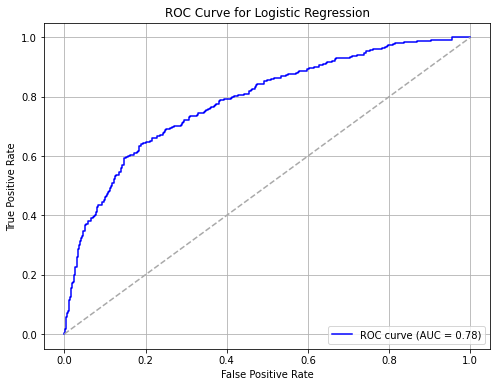

In [6]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

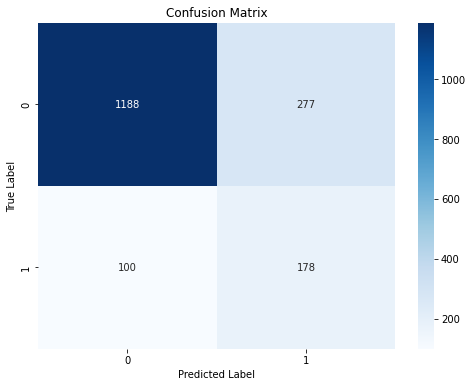

In [7]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

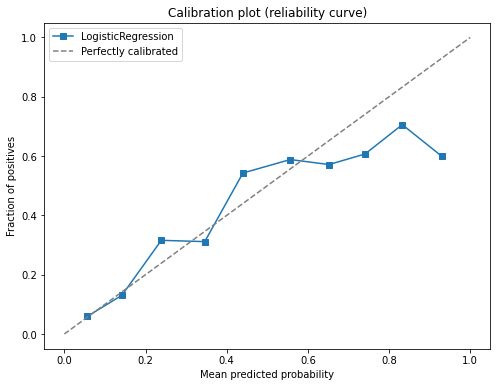

In [8]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y, y_pred_proba, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="LogisticRegression")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot (reliability curve)')
plt.legend()
plt.show()